In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import string
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier

# Initialize stemmer and load word clusters
st = stopwords.words('english')
stemmer = PorterStemmer()
sia = SentimentIntensityAnalyzer()

word_clusters = {}

def loadwordclusters():
    with open('50mpaths2', 'r', encoding='utf-8') as infile:
        for line in infile:
            items = str.strip(line).split()
            class_ = items[0]
            term = items[1]
            word_clusters[term] = class_
    return word_clusters

def getclusterfeatures(sent):
    sent = sent.lower()
    terms = word_tokenize(sent)
    cluster_string = ''
    for t in terms:
        if t in word_clusters.keys():
            cluster_string += 'clust_' + word_clusters[t] + '_clust '
    return str.strip(cluster_string)

def preprocess_text(raw_text):
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    raw_text = raw_text.translate(translator)
    # Stemming and lowercasing
    words = [stemmer.stem(w) for w in word_tokenize(raw_text.lower())]
    return " ".join(words)

# Load data
train_df = pd.read_csv('fallreports_2023-9-21_train.csv')
test_df = pd.read_csv('fallreports_2023-9-21_test.csv')

train_df['fall_description'].fillna('', inplace=True)
test_df['fall_description'].fillna('', inplace=True)

# Preprocessing
train_df['fall_description'] = train_df['fall_description'].apply(preprocess_text)
test_df['fall_description'] = test_df['fall_description'].apply(preprocess_text)

# Feature Engineering

# 1. Sentiment feature
train_df['sentiment'] = train_df['fall_description'].apply(lambda x: sia.polarity_scores(x)['compound'])
test_df['sentiment'] = test_df['fall_description'].apply(lambda x: sia.polarity_scores(x)['compound'])

# 2. Text length features
train_df['text_len'] = train_df['fall_description'].apply(lambda x: len(word_tokenize(x)))
test_df['text_len'] = test_df['fall_description'].apply(lambda x: len(word_tokenize(x)))

# 3. TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words=st, tokenizer=word_tokenize)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['fall_description'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['fall_description'])

# 4. Bigram feature
bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=10000, stop_words=st, tokenizer=word_tokenize)
X_train_bigram = bigram_vectorizer.fit_transform(train_df['fall_description'])
X_test_bigram = bigram_vectorizer.transform(test_df['fall_description'])

# 5. Word clusters feature
word_clusters = loadwordclusters()
train_df['cluster_feature'] = train_df['fall_description'].apply(getclusterfeatures)
test_df['cluster_feature'] = test_df['fall_description'].apply(getclusterfeatures)

clustervectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X_train_clusters = clustervectorizer.fit_transform(train_df['cluster_feature']).toarray()
X_test_clusters = clustervectorizer.transform(test_df['cluster_feature']).toarray()


# Combine features
X_train_combined = hstack([X_train_tfidf, X_train_bigram, train_df[['sentiment', 'text_len']].values, X_train_clusters], format='csr')
X_test_combined = hstack([X_test_tfidf, X_test_bigram, test_df[['sentiment', 'text_len']].values, X_test_clusters], format='csr')


y_train = train_df['fog_q_class']
y_test = test_df['fog_q_class']

# Classifier Implementation and Evaluation

# Define classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Define hyperparameters for GridSearch
param_grids = {
    'Naive Bayes': {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'SVM': {
        'C': [0.01, 0.1, 0.5, 1, 10, 50],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    },
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 8]},
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}


results = {}
tuned_classifiers = {}

# GridSearch and Evaluation
for name, clf in classifiers.items():
    print(f"Processing GridSearch for {name}...")
    
    # Convert the sparse matrix to a dense one for GaussianNB during training
    if name == "Naive Bayes":
        X_train_dense = X_train_combined.toarray()
        gs_clf = GridSearchCV(clf, param_grids[name], cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)
        gs_clf.fit(X_train_dense, y_train)
    else:
        gs_clf = GridSearchCV(clf, param_grids[name], cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)
        gs_clf.fit(X_train_combined, y_train)

    tuned_classifiers[name] = gs_clf.best_estimator_
    
    # Convert the sparse matrix to a dense one for GaussianNB during prediction
    if name == "Naive Bayes":
        X_test_dense = X_test_combined.toarray()
        y_pred = gs_clf.predict(X_test_dense)
    else:
        y_pred = gs_clf.predict(X_test_combined)

    accuracy = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    results[name] = (accuracy, f1_micro, f1_macro)
    print(f"Best parameters for {name}: {gs_clf.best_params_}")
    print(f"Accuracy for {name}: {accuracy}, F1 (Micro): {f1_micro}, F1 (Macro): {f1_macro}")
    print("--------------------------------------")


# Ensemble Method
ensemble_clf = VotingClassifier(estimators=[
    ('Random Forest', tuned_classifiers['Random Forest']),
    ('SVM', tuned_classifiers['SVM']),
    ('Logistic Regression', tuned_classifiers['Logistic Regression']),
    ('Gradient Boosting', tuned_classifiers['Gradient Boosting']),
], voting='hard')

ensemble_clf.fit(X_train_combined, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred_ensemble)
f1_micro = f1_score(y_test, y_pred_ensemble, average='micro')
f1_macro = f1_score(y_test, y_pred_ensemble, average='macro')
results['Ensemble'] = (accuracy, f1_micro, f1_macro)

# Print results
for model, metrics in results.items():
    print(f"{model} - Accuracy: {metrics[0]}, F1 (Micro): {metrics[1]}, F1 (Macro): {metrics[2]}")

#Outputs:
# Processing GridSearch for Naive Bayes...
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Best parameters for Naive Bayes: {'var_smoothing': 1e-07}
# Accuracy for Naive Bayes: 0.7323943661971831, F1 (Micro): 0.7323943661971831, F1 (Macro): 0.7315422885572138
# --------------------------------------
# Processing GridSearch for Random Forest...
# Fitting 5 folds for each of 36 candidates, totalling 180 fits
# Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50}
# Accuracy for Random Forest: 0.7464788732394366, F1 (Micro): 0.7464788732394367, F1 (Macro): 0.7376847290640394
# --------------------------------------
# Processing GridSearch for SVM...
# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# Best parameters for SVM: {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
# Accuracy for SVM: 0.7605633802816901, F1 (Micro): 0.7605633802816902, F1 (Macro): 0.7574844283705042
# --------------------------------------
# Processing GridSearch for Logistic Regression...
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
# Accuracy for Logistic Regression: 0.6197183098591549, F1 (Micro): 0.6197183098591549, F1 (Macro): 0.6185074626865672
# --------------------------------------
# Processing GridSearch for Gradient Boosting...
# Fitting 5 folds for each of 27 candidates, totalling 135 fits
# Best parameters for Gradient Boosting: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 150}
# Accuracy for Gradient Boosting: 0.7183098591549296, F1 (Micro): 0.7183098591549296, F1 (Macro): 0.7169059011164274
# --------------------------------------
# Processing GridSearch for K-Nearest Neighbors...
# Fitting 5 folds for each of 120 candidates, totalling 600 fits
# Best parameters for K-Nearest Neighbors: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
# Accuracy for K-Nearest Neighbors: 0.676056338028169, F1 (Micro): 0.676056338028169, F1 (Macro): 0.6695001011940902
# --------------------------------------
# Naive Bayes - Accuracy: 0.7323943661971831, F1 (Micro): 0.7323943661971831, F1 (Macro): 0.7315422885572138
# Random Forest - Accuracy: 0.7464788732394366, F1 (Micro): 0.7464788732394367, F1 (Macro): 0.7376847290640394
# SVM - Accuracy: 0.7605633802816901, F1 (Micro): 0.7605633802816902, F1 (Macro): 0.7574844283705042
# Logistic Regression - Accuracy: 0.6197183098591549, F1 (Micro): 0.6197183098591549, F1 (Macro): 0.6185074626865672
# Gradient Boosting - Accuracy: 0.7183098591549296, F1 (Micro): 0.7183098591549296, F1 (Macro): 0.7169059011164274
# K-Nearest Neighbors - Accuracy: 0.676056338028169, F1 (Micro): 0.676056338028169, F1 (Macro): 0.6695001011940902
# Ensemble - Accuracy: 0.7183098591549296, F1 (Micro): 0.7183098591549296, F1 (Macro): 0.7113821138211383


C:\Users\Zhishuo Han\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Processing GridSearch for Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Naive Bayes: {'var_smoothing': 1e-07}
Accuracy for Naive Bayes: 0.7323943661971831, F1 (Micro): 0.7323943661971831, F1 (Macro): 0.7315422885572138
--------------------------------------
Processing GridSearch for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy for Random Forest: 0.7464788732394366, F1 (Micro): 0.7464788732394367, F1 (Macro): 0.7376847290640394
--------------------------------------
Processing GridSearch for SVM...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters for SVM: {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy for SVM: 0.7605633802816901, F1 (Micro): 0.7605633802816902, F1 (Macro): 0.7574844283705042
--------------------------------------
Processing GridSearch for Logisti

C:\Users\Zhishuo Han\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Best parameters for K-Nearest Neighbors: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy for K-Nearest Neighbors: 0.676056338028169, F1 (Micro): 0.676056338028169, F1 (Macro): 0.6695001011940902
--------------------------------------
Naive Bayes - Accuracy: 0.7323943661971831, F1 (Micro): 0.7323943661971831, F1 (Macro): 0.7315422885572138
Random Forest - Accuracy: 0.7464788732394366, F1 (Micro): 0.7464788732394367, F1 (Macro): 0.7376847290640394
SVM - Accuracy: 0.7605633802816901, F1 (Micro): 0.7605633802816902, F1 (Macro): 0.7574844283705042
Logistic Regression - Accuracy: 0.6197183098591549, F1 (Micro): 0.6197183098591549, F1 (Macro): 0.6185074626865672
Gradient Boosting - Accuracy: 0.7183098591549296, F1 (Micro): 0.7183098591549296, F1 (Macro): 0.7169059011164274
K-Nearest Neighbors - Accuracy: 0.676056338028169, F1 (Micro): 0.676056338028169, F1 (Macro): 0.6695001011940902
Ensemble - Accuracy: 0.7183098591549296, F1 (Micro): 0.718309859

Using the best classifier: SVM for the analysis.


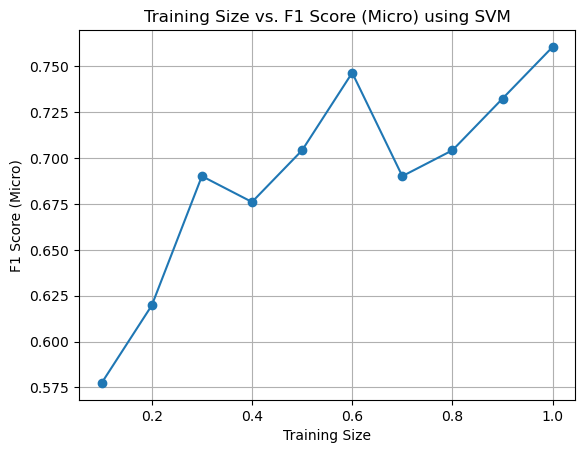

In [2]:
# Select classifier with highest F1 (Micro)
best_classifier_name = max(results, key=lambda k: results[k][1]) 
best_classifier = tuned_classifiers[best_classifier_name]

print(f"Using the best classifier: {best_classifier_name} for the analysis.")

import numpy as np
import matplotlib.pyplot as plt

sizes = np.linspace(0.1, 1, 10)
f1_scores = []

for size in sizes:
    subset_size = int(size * X_train_combined.shape[0])
    X_subset = X_train_combined[:subset_size]  
    y_subset = y_train[:subset_size]
    
    best_classifier.fit(X_subset, y_subset)
    y_pred = best_classifier.predict(X_test_combined)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_scores.append(f1_micro)

plt.plot(sizes, f1_scores, marker='o')
plt.title(f'Training Size vs. F1 Score (Micro) using {best_classifier_name}')
plt.xlabel('Training Size')
plt.ylabel('F1 Score (Micro)')
plt.grid(True)
plt.show()

#Graph is presented in the report


In [3]:
feature_ranges = {
    "TF-IDF": (0, X_train_tfidf.shape[1]),
    "Bigram": (X_train_tfidf.shape[1], X_train_tfidf.shape[1] + X_train_bigram.shape[1]),
    "Sentiment": (X_train_tfidf.shape[1] + X_train_bigram.shape[1], X_train_tfidf.shape[1] + X_train_bigram.shape[1] + 1),
    "Text Length": (X_train_tfidf.shape[1] + X_train_bigram.shape[1] + 1, X_train_tfidf.shape[1] + X_train_bigram.shape[1] + 2),
    "Word Clusters": (X_train_tfidf.shape[1] + X_train_bigram.shape[1] + 2, X_train_tfidf.shape[1] + X_train_bigram.shape[1] + 2 + X_train_clusters.shape[1])
}


for feature_name, (start, end) in feature_ranges.items():
    # Remove the feature set from training and testing data
    X_train_ablated = hstack([X_train_combined[:, :start], X_train_combined[:, end:]], format='csr')
    X_test_ablated = hstack([X_test_combined[:, :start], X_test_combined[:, end:]], format='csr')
    
    # Train and test
    best_classifier.fit(X_train_ablated, y_train)
    y_pred = best_classifier.predict(X_test_ablated)
    accuracy = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    
    print(f"Results without {feature_name}:")
    print(f"Accuracy: {accuracy:.4f}, F1 (Micro): {f1_micro:.4f}")
    print("--------------------------------------------------")

#Output:
# Results without TF-IDF:
# Accuracy: 0.7606, F1 (Micro): 0.7606
# --------------------------------------------------
# Results without Bigram:
# Accuracy: 0.7606, F1 (Micro): 0.7606
# --------------------------------------------------
# Results without Sentiment:
# Accuracy: 0.7606, F1 (Micro): 0.7606
# --------------------------------------------------
# Results without Text Length:
# Accuracy: 0.7465, F1 (Micro): 0.7465
# --------------------------------------------------
# Results without Word Clusters:
# Accuracy: 0.7465, F1 (Micro): 0.7465
# --------------------------------------------------

Results without TF-IDF:
Accuracy: 0.7606, F1 (Micro): 0.7606
--------------------------------------------------
Results without Bigram:
Accuracy: 0.7606, F1 (Micro): 0.7606
--------------------------------------------------
Results without Sentiment:
Accuracy: 0.7606, F1 (Micro): 0.7606
--------------------------------------------------
Results without Text Length:
Accuracy: 0.7465, F1 (Micro): 0.7465
--------------------------------------------------
Results without Word Clusters:
Accuracy: 0.7465, F1 (Micro): 0.7465
--------------------------------------------------
